# Tuning parameters and cross validation

This notebook illustrates the "master algorithm". How to make
optimal use of your data, apply preprocessing steps, tune
hyper-parameters and get an estimate of your algorithm on
future data.

In [1]:
%config InlineBackend.figure_format='retina'
%matplotlib inline

import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (8, 8)
plt.rcParams["font.size"] = 14

# Train, validation and test

Using the breast cancer dataset once again.

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import scale
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

## The full pipeline

This is a full example of how you would pick the best value for `n_neighbors`, make optimal use of your dataset, and obtain a prediction for your generalisation error.

It looks simple and straightforward. It is. However the most frequent source of mistakes in real world problems is "information leakage" of some form or another. When this happens the performance estimates become biased and essentially useless.

In [3]:
from sklearn.model_selection import cross_val_score

data = load_breast_cancer()
X, y = data.data, data.target
# features are on very different scales so let's
# scale them all.
X = scale(X)

neighbors = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2)

cross_val_scores = []
for i in neighbors:
    knn = KNeighborsClassifier(n_neighbors=i)
    # this function performs a loop of splitting the data,
    # fitting one split, evaluating on the others
    scores = cross_val_score(knn, X_train, y_train, cv=10)
    cross_val_scores.append(np.mean(scores))

print("best cross-validation score: {:.3f}".format(np.max(cross_val_scores)))
best_n_neighbors = neighbors[np.argmax(cross_val_scores)]

print("best n_neighbors: {}".format(best_n_neighbors))

# fit on the whole training dataset
knn = KNeighborsClassifier(n_neighbors=best_n_neighbors)
knn.fit(X_train, y_train)
print("test-set score: {:.3f}".format(knn.score(X_test, y_test)))

best cross-validation score: 0.972
best n_neighbors: 7
test-set score: 0.965


## Preprocessing and pipelines

Any preprocessing steps you want to perform need to be performed inside the cross-validation loop. Checkout scikit-learn's `Pipeline` to make this nice and easy to use.

### Question
What mistake did we make at the beginning of this notebook?
```
data = load_breast_cancer()
X, y = data.data, data.target

# features are on very different scales so let's
# scale them all.
X = scale(X)
```

Use `make_pipeline` to create a new estimator that scales the data
and fits a `KNeighborsClassifier` to the data. Find the best setting
for `n_neighbors`, and obtain an estimate of the accuracy on unseen
data.

In [4]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [5]:
# BEGIN SOLUTION
neighbors = [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=2)

cross_val_scores = []
for i in neighbors:
    pipeline = make_pipeline(StandardScaler(),
                             KNeighborsClassifier(n_neighbors=i)
                            )
    # this function performs a loop of splitting the data,
    # fitting one split, evaluating on the others
    scores = cross_val_score(pipeline, X_train, y_train, cv=10)
    cross_val_scores.append(np.mean(scores))

print("best cross-validation score: {:.3f}".format(np.max(cross_val_scores)))
best_n_neighbors = neighbors[np.argmax(cross_val_scores)]

print("best n_neighbors: {}".format(best_n_neighbors))

pipeline = make_pipeline(StandardScaler(),
                         KNeighborsClassifier(n_neighbors=best_n_neighbors)
                        )
pipeline.fit(X_train, y_train)
print("test-set score: {:.3f}".format(pipeline.score(X_test, y_test)))
                         
# END SOLUTION

best cross-validation score: 0.972
best n_neighbors: 7
test-set score: 0.965


The important thing is that your preprocessing steps, just like your final algorithm must nto see any data "from the future". When you compute the constants by which to scale the data you must not look at the samples in the testing data as that simulates the future.

This does mean you need to think about how to handle samples very far away from what you saw in training, or if you are applying other kinds of transforms how to handle values you have never seen, etc. The effect of this is precisely what you want to test and evaluate when you "simulate the future" by splitting your data.

## Hyper-parameter optimisation

You can see there are more and more hyper-parameters cropping up. These are parameters that can not be directly learnt from the data. The only way to know what to set them to is a mixture of prior experience of what ranges of values "work well" and then trying those values.

Not optimising your hyper-parameters is a fundamental mistake. It can make a huge difference to the performance of your model and especially when you are comparing different types of models (say ensembles of decisions trees to neural networks) you need to optimise the architecture of both! Otherwise you might as well flip a coin in order ot determine which algorithm is better.

The above `for`-loop works for one parameter but what if we wanted to tune two parameters?
We would end up having to loop over both parameters with two `for`-loops. For three we would have to write three loops, etc. This is such a common task that scikit-learn has some builtin tools for this.

In scikit-learn there is `GridSearchCV` and `RandomizedSearchCV`. They themselves follow the `Estimator` API. When you call `fit()` they perform the "master algorithm".

In [6]:
from sklearn.model_selection import GridSearchCV


X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

pipeline = make_pipeline(StandardScaler(),
                         KNeighborsClassifier()
                         )

# parameters for each step in a pipeline
# are prefixed with the name of the step
# which `make_pipeline` derives from the 
# class name.
# Find out from the documentation how to
# specify all odd values between one and 15
# as values to try for n_neighbors
### BEGIN SOLUTION
param_grid = {'kneighborsclassifier__n_neighbors':  np.arange(1, 15, 2)}
### END SOLUTION

# GridSearchCV will also re-fit your estimator
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=10)
grid.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))
print("test-set score: {:.3f}".format(grid.score(X_test, y_test)))

best mean cross-validation score: 0.974
best parameters: {'kneighborsclassifier__n_neighbors': 3}
test-set score: 0.958


## Exercise

Replace `GridSearchCV` with `RandomizedSearchCV` in the above setup.

When or why does it make sense to prefer random search over grid search?

In [7]:
# you might need to install scipy if you haven't already
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

### BEGIN SOLUTION
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

pipeline = make_pipeline(StandardScaler(),
                         KNeighborsClassifier()
                         )


param_distribution = {
    'kneighborsclassifier__n_neighbors':  sp_randint(1, 15)}

# GridSearchCV will also re-fit your estimator
randomized = RandomizedSearchCV(pipeline,
                                param_distributions=param_distribution,
                                n_iter=4, cv=10)
randomized.fit(X_train, y_train)

print("best mean cross-validation score: {:.3f}".format(randomized.best_score_))
print("best parameters: {}".format(randomized.best_params_))
print("test-set score: {:.3f}".format(randomized.score(X_test, y_test)))

### END SOLUTION

best mean cross-validation score: 0.969
best parameters: {'kneighborsclassifier__n_neighbors': 12}
test-set score: 0.965


## Summary

Because the score on the validation set is a random variable it will fluctuate low and high as we try different classification techniques. This means if you try enough different techniques you will end up picking one which "gets lucky" on the dataset you use to measure performance.

This means that the performance on the validation set is not an unbiased estimate of the generalisation error. Instead we need to have yet another data set that we did not look at during the optimisation process and use that to estimate the performance on future data.

Great visual guide to parameter tuning and the bias-variance trade-off:

http://www.r2d3.us/visual-intro-to-machine-learning-part-2/

---

## Bonus: Bias-Variance trade-off

It can be shown that the best method for making a prediction $\hat y$ at $x$ is to predict the average of all training examples for which $X = x$. When "best" is defined by the average squared error. In practice there is at most one training point at each $x$. In practice this means we settle for:
$$
\hat f(x) = \mathrm{Ave}\left(y_i \mid x_i \in N_k(x)\right)
$$
where $N_k(x)$ is the neighbourhood containing $k$ points from $\mathcal{T}$ nearest to $x$. This is exactly what kNN does. So why not use it always and for everything?

The curse of dimensionality: as the number of dimensions increases you need an exponentially larger number of training samples to keep $k$ constant.

By making assumptions about the (local) shape of the function we are trying to model we can counteract this and get more stable predictions.

Lienar regression assumes that $f(x)$ is well approximated by a globally linear function.

In contrast kNN assumes that $f(x)$ is well approximated by a locally constant function.

The latter is more flexible, but you have to pay a price for this flexibility. If you do not need the flexibility you can obtain a more stable estimate by making more assumptions.

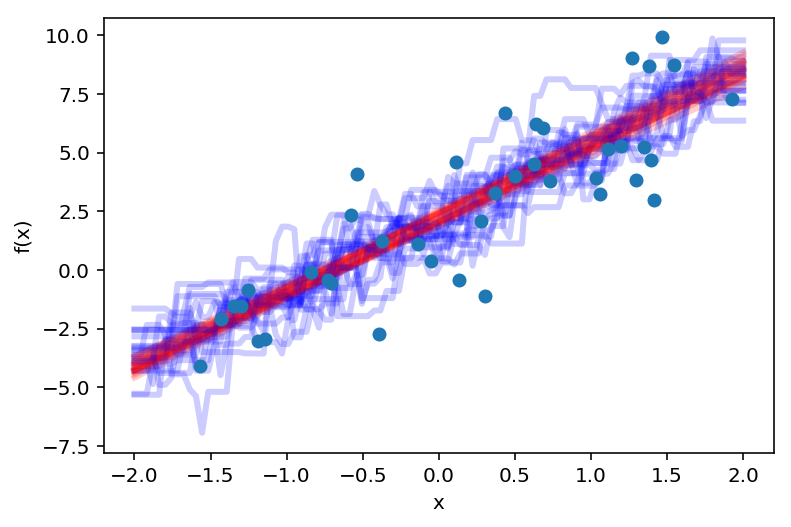

In [8]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression


def non_linear_f(x):
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)


def linear_f(x, beta0=2.19, beta1=3.141):
    rng = np.random.RandomState()
    return beta0 + beta1 * x + rng.randn(x.shape[0]) * 2.


def make_linear_data():
    x = np.linspace(-2, 2, 1000)
    rng = np.random.RandomState()
    rng.shuffle(x)
    X = np.sort(x[:40])
    y = linear_f(X)

    X = X.reshape(-1, 1)
    return X, y


def make_nonlinear_data():
    x = np.linspace(-2, 2, 1000)
    rng = np.random.RandomState()
    rng.shuffle(x)
    X = np.sort(x[:40])
    y = non_linear_f(X)

    X = X.reshape(-1, 1)
    return X, y


# show a noisy but linear data set, compare variance of kNN with linear regression
line = np.linspace(-2, 2, 100).reshape(-1, 1)

for n in range(20):
    X, y = make_linear_data()
    rgr = LinearRegression()
    rgr.fit(X, y)
    plt.plot(line, rgr.predict(line), '-r', alpha=0.2, label='linear model', lw=3)
    
    rgr = KNeighborsRegressor(n_neighbors=3)
    rgr.fit(X, y)
    plt.plot(line, rgr.predict(line), '-b', alpha=0.2, label='kNN', lw=3)
    #break

plt.plot(X, y, 'o', label='true f(x)')
plt.xlabel('x')
plt.ylabel("f(x)");
#plt.legend(loc='best');

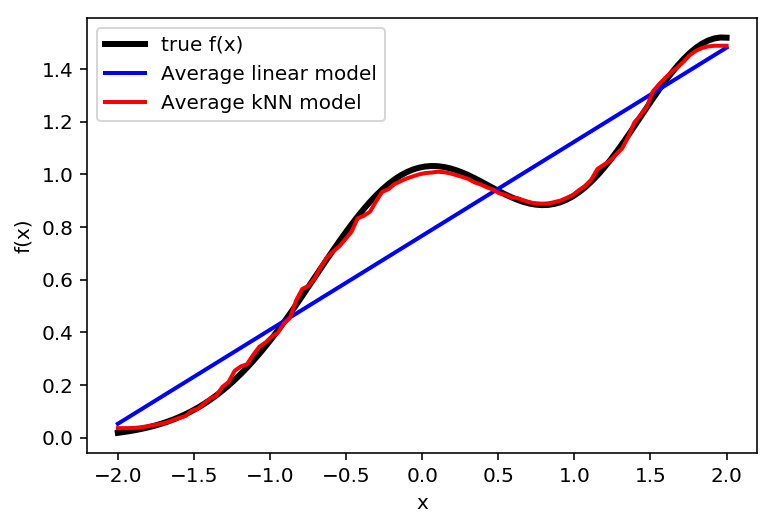

In [9]:
# use a **non linear** data set, compare bias of kNN with linear regression
plt.plot(line, non_linear_f(line), 'k-', lw=3, label='true f(x)')
linear = []
knn = []
for n in range(20):
    X, y = make_nonlinear_data()
    rgr = LinearRegression()
    rgr.fit(X, y)
    linear.append(rgr.predict(line))
    
    rgr = KNeighborsRegressor(n_neighbors=3)
    rgr.fit(X, y)
    knn.append(rgr.predict(line))

plt.plot(line, np.array(linear).mean(axis=0), '-b', lw=2, label='Average linear model')
plt.plot(line, np.array(knn).mean(axis=0), '-r', lw=2, label='Average kNN model');
plt.legend(loc='best');
plt.xlabel('x');
plt.ylabel('f(x)');